In [109]:
import re
import pandas as pd
import bs4
import requests
import spacy
from spacy import displacy

In [2]:
nlp = spacy.load('en_core_web_sm')

from spacy.matcher import Matcher 
from spacy.tokens import Span 

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm

pd.set_option('display.max_colwidth', 200)
%matplotlib inline

In [4]:
pip install matplotlib

Note: you may need to restart the kernel to use updated packages.


In [3]:
candidate_sentences = pd.read_csv("transcript.csv")
candidate_sentences.shape

(1, 1)

In [4]:
candidate_sentences['transcript'].sample(1)

0    Bob Dylan wrote a song
Name: transcript, dtype: object

In [5]:
doc = nlp("Bob Dylan wrote a song")

for tok in doc:
  print(tok.text, "...", tok.dep_)

Bob ... compound
Dylan ... nsubj
wrote ... ROOT
a ... det
song ... dobj


In [6]:
def get_entities(sent):
  ## chunk 1
  ent1 = ""
  ent2 = ""

    
  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  #############################################################
  
  for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
    
        
      
      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""     
     

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = tok.text
        
    
        
        
      ## chunk 5  
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_dep = tok.dep_
  #############################################################

  return ent1.strip(), ent2.strip()

In [90]:
get_entities("columbus was born in 1451")

('columbus', '1451')

In [7]:
entity_pairs = []

for i in tqdm(candidate_sentences["transcript"]):
  entity_pairs.append(get_entities(i))

100%|██████████| 1/1 [00:00<00:00, 83.54it/s]


In [8]:
entity_pairs

[('Bob Dylan', 'song')]

In [9]:
def get_relation(sent):

  doc = nlp(sent)

  # Matcher class object 
  matcher = Matcher(nlp.vocab)

  #define the pattern 
  pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

  matcher.add("matching_1", [pattern]) 

  matches = matcher(doc)
  k = len(matches) - 1

  span = doc[matches[k][1]:matches[k][2]] 

  return(span.text)

In [25]:
get_relation("columbus was born in 1451")

'born in'

In [89]:
print("the entities are: ", get_entities("Bob Dylan wrote songs"), "and the relation is: ", get_relation("Dylan wrote songs"))

the entities are:  ('Bob Dylan', 'songs') and the relation is:  wrote


In [10]:
relations = [get_relation(i) for i in tqdm(candidate_sentences['transcript'])]

100%|██████████| 1/1 [00:00<00:00, 83.51it/s]


In [11]:
pd.Series(relations).value_counts()

wrote    1
dtype: int64

In [12]:
print("the entities are: ", entity_pairs, "and the relation is: ", get_relation(i))

the entities are:  [('Bob Dylan', 'song')] and the relation is:  wrote


In [13]:
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

In [14]:
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())


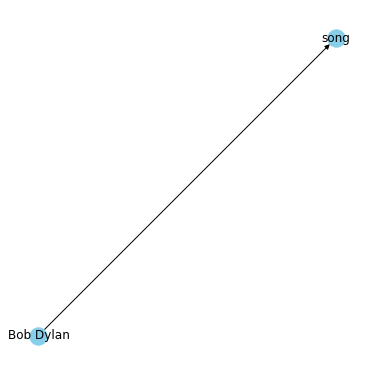

In [23]:
from matplotlib import pyplot as plt
plt.figure(figsize=(5,5))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

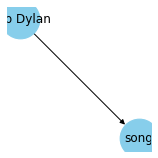

In [17]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="wrote"], "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(2,2))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()